In [1]:
import sys
import os
from pathlib import Path


import matplotlib.cm as cm

sys.path.append(Path.cwd().parent.joinpath("source").as_posix())

from utils import read_tiff, plot_sar, save_tiff
from outliers_remover import OutliersRemover

import plotly.offline as pyo
import plotly.graph_objects as go

# Set notebook mode to work in offline
pyo.init_notebook_mode()

import random
random.seed(1)
direction = "ascending"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = f"/mnt/SAR_images/processed/RCR/cropped/{direction}"
image_paths = []
for file in sorted(os.listdir(data_dir)):
    if file.endswith(".tif"):
        filepath = os.path.join(data_dir, file)
        image_paths.append(filepath)

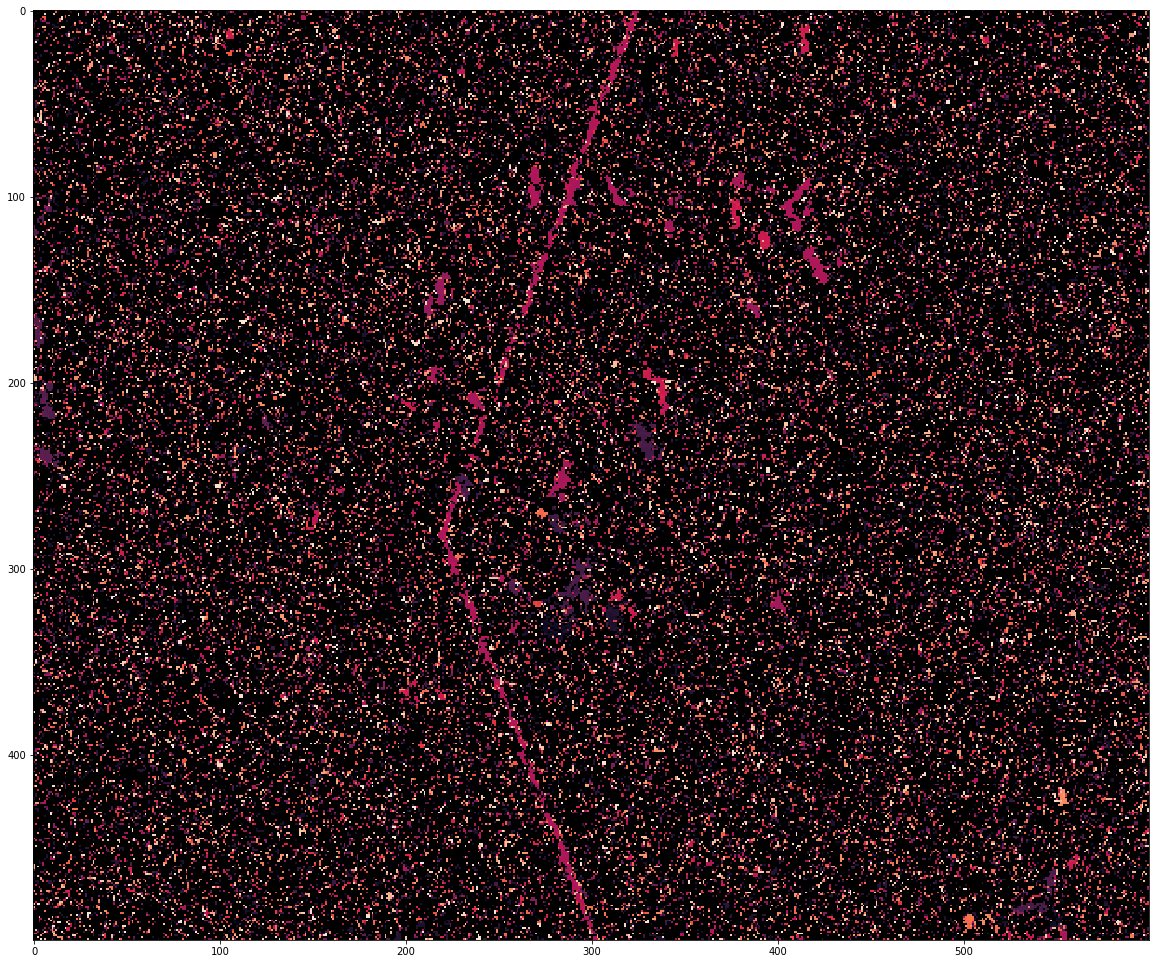

In [4]:
index_shadows = read_tiff(f'/mnt/SAR_images/processed/shadows/cropped/{direction}/detected_shadows_image_indexes.tif')

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(index_shadows) +1)))
color_index_shadows = colors[index_shadows.astype(int) + 1]
plt.imshow(color_index_shadows, interpolation='nearest')
plt.show()
#plt.imsave( '/mnt/hdd/SAR_images/shadows/cropped/colored_index.png', color_index_shadows)

In [5]:
threshold = 8

outliers_remover = OutliersRemover(
    filepath=f'/mnt/SAR_images/processed/shadows/cropped/{direction}/detected_shadows_image_indexes.tif',
    threshold=threshold,
    output_dir=f'/mnt/SAR_images/processed/shadows/cropped/{direction}/',
    output_filename=f"filtered_shadow_image_threshold_{threshold}.tif",
    dark_value=-1,
    time_range = [25, 40]
)

print(image_paths[25], image_paths[40])
new_image, detected_coords_of_shadows, detected_groups_of_shadows = outliers_remover.main()

/mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20170411.tif /mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20180811.tif


300000it [00:00, 344255.73it/s]


Saving image at /mnt/SAR_images/processed/shadows/cropped/ascending/filtered_shadow_image_threshold_8.tif


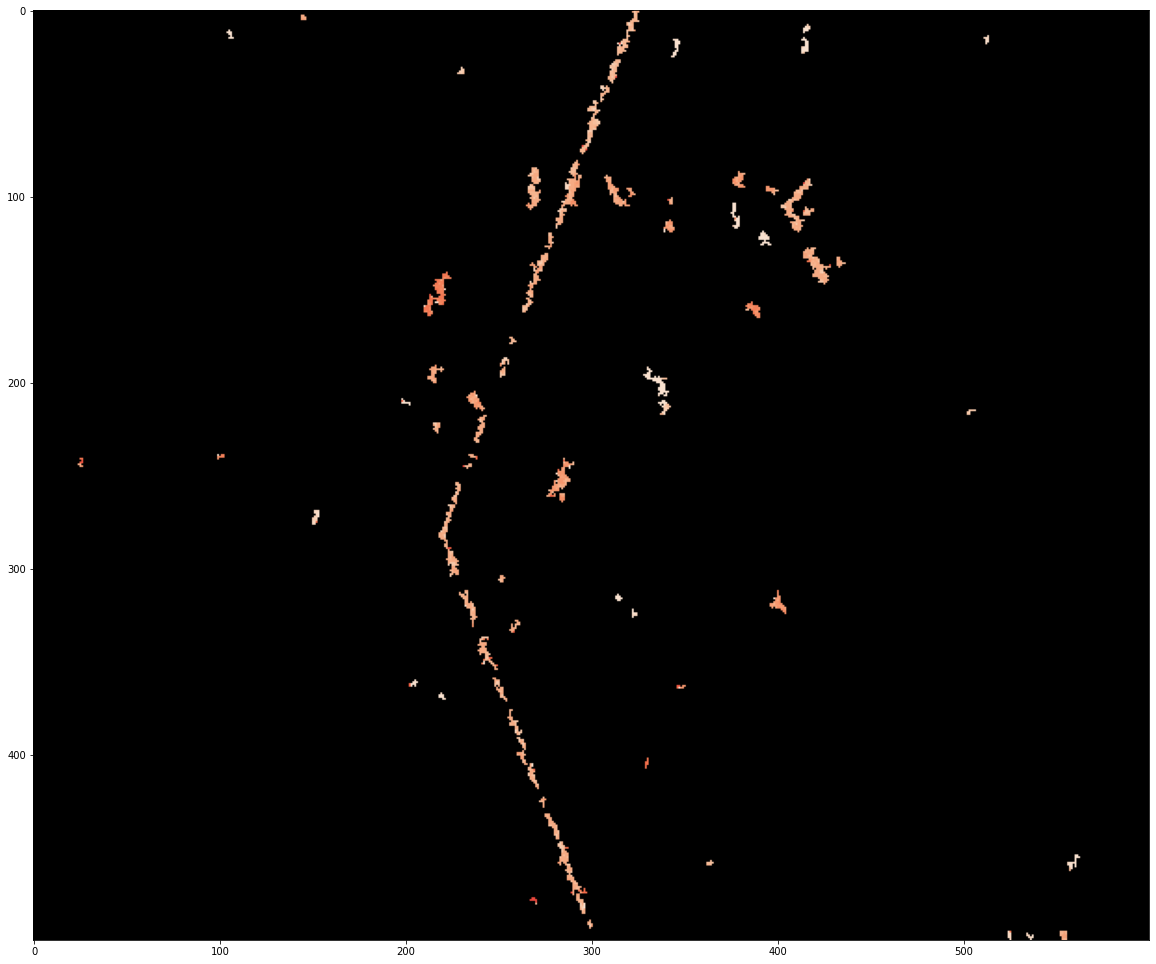

In [6]:
im = np.ones_like(new_image) * -1
where =  new_image < 40
im[where] = new_image[where]

colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(new_image) +1)))
color_new_image = colors[new_image.astype(int) + 1]
plt.imshow(color_new_image)
plt.show()

In [7]:
group_image = outliers_remover.create_group_image(
                    new_image, 
                    detected_groups_of_shadows,
                    filename="detected_groups_shadow.tif",
                    save=True
)

79it [00:00, 103256.47it/s]

Saving image at /mnt/SAR_images/processed/shadows/cropped/ascending/detected_groups_shadow.tif


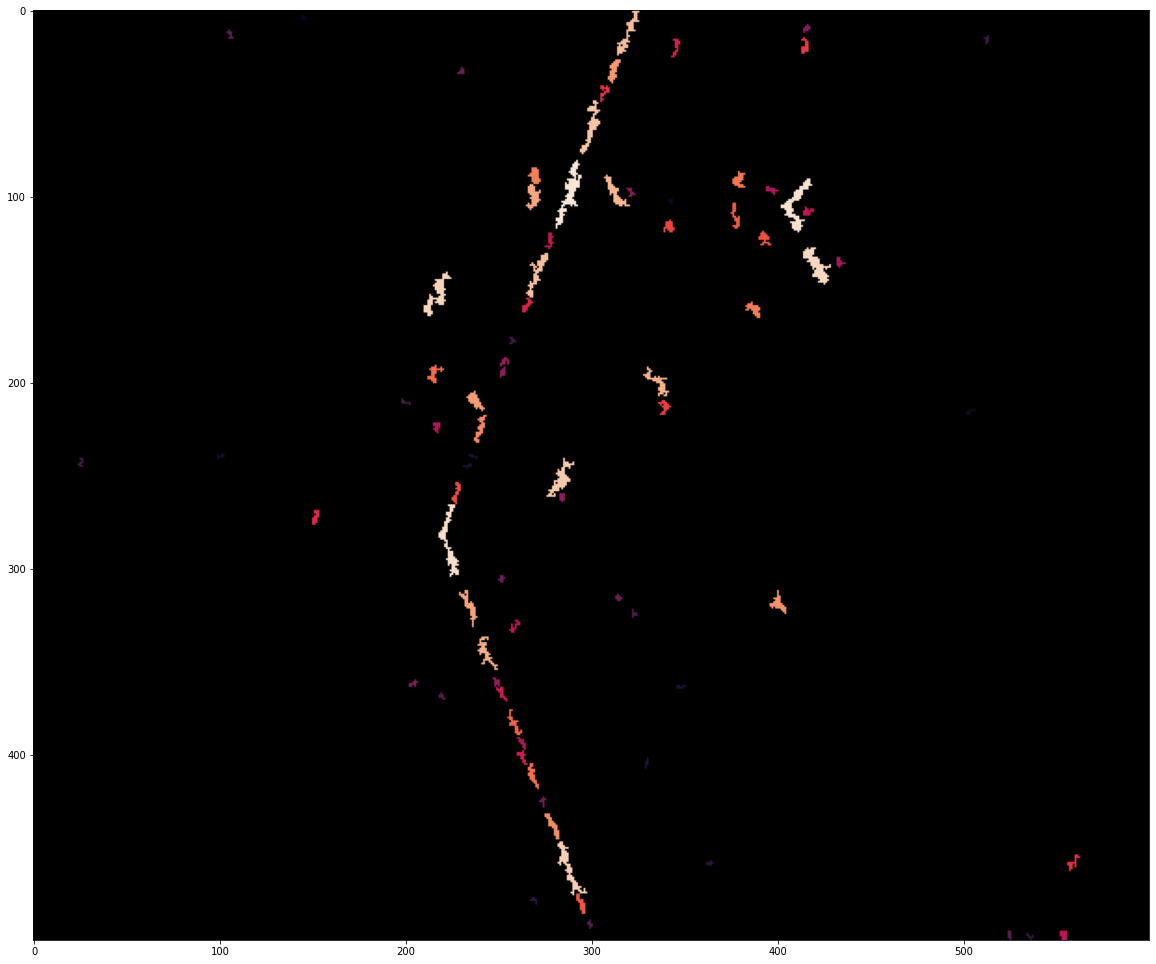

In [8]:
colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(group_image) +1)))
color_group_image = colors[group_image.astype(int) + 1]
plt.imshow(color_group_image)
plt.show()

/mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20170411.tif /mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20180811.tif


300000it [00:00, 370919.45it/s]


Saving image at /mnt/SAR_images/processed/shadows/cropped/ascending/filtered_shadow_image_threshold_8.tif
/mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20170411.tif /mnt/SAR_images/processed/RCR/cropped/ascending/rcr_20180811.tif


300000it [00:00, 392769.84it/s]


Saving image at /mnt/SAR_images/processed/shadows/cropped/descending/filtered_shadow_image_threshold_8.tif
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


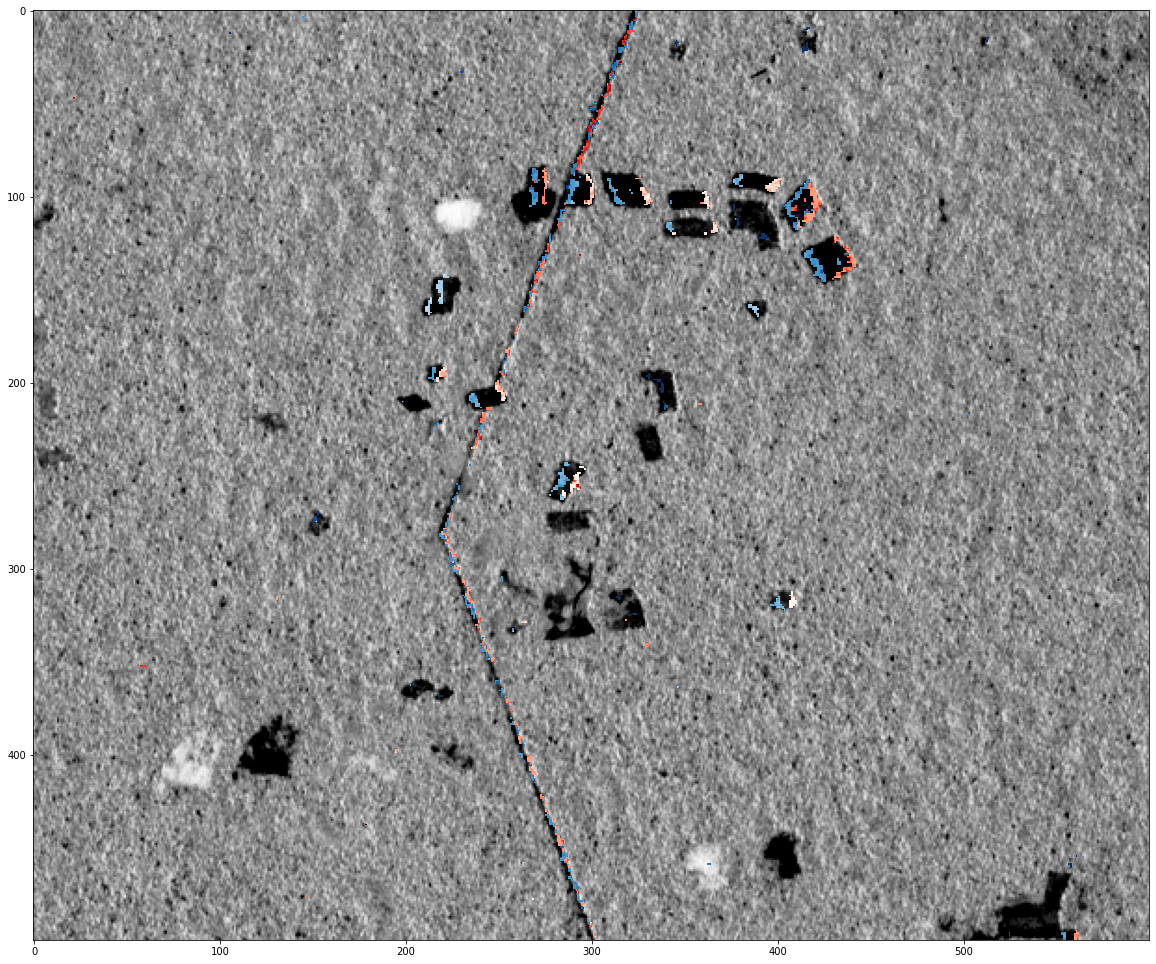

In [12]:
import cv2
threshold = 8
masks = []
shadows = []
color_shadows = []
time_ranges = [[25, 40], [0,np.inf]]
for i,direction in enumerate(['ascending', 'descending']):
    outliers_remover = OutliersRemover(
        filepath=f'/mnt/SAR_images/processed/shadows/cropped/{direction}/detected_shadows_image_indexes.tif',
        threshold=threshold,
        output_dir=f'/mnt/SAR_images/processed/shadows/cropped/{direction}/',
        output_filename=f"filtered_shadow_image_threshold_{threshold}.tif",
        dark_value=-1,
        time_range = time_ranges[i]
    )

    print(image_paths[25], image_paths[40])
    new_image, detected_coords_of_shadows, detected_groups_of_shadows = outliers_remover.main()

    colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(new_image) +1)))
    color_new_image = colors[new_image.astype(int) + 1]
    shadows.append(new_image)
    color_shadows.append(color_new_image)
    masks.append((new_image != -1).astype(float)) 

    # plt.imshow(color_new_image)

B03image = read_tiff('/mnt/SAR_images/couleur/cropped/T18MUU_20180921T152629_B03_cropped.tiff')


t = np.mean(B03image)+3*np.std(B03image)
t = np.clip(B03image,0,t)

print(masks[1]  )
fig, ax = plt.subplots(1)
ax.imshow(t, cmap = cm.get_cmap('Greys'))
ax.imshow(np.ma.masked_where(shadows[0] == -1, shadows[0]), cmap=plt.get_cmap('Blues'))
ax.imshow(np.ma.masked_where(shadows[1] == -1, shadows[1]), cmap=plt.get_cmap('Reds'))
# ax.imshow(color_shadows[0], alpha = masks[0])
# ax.imshow(color_shadows[1], alpha = masks[1])
plt.savefig("out.png")


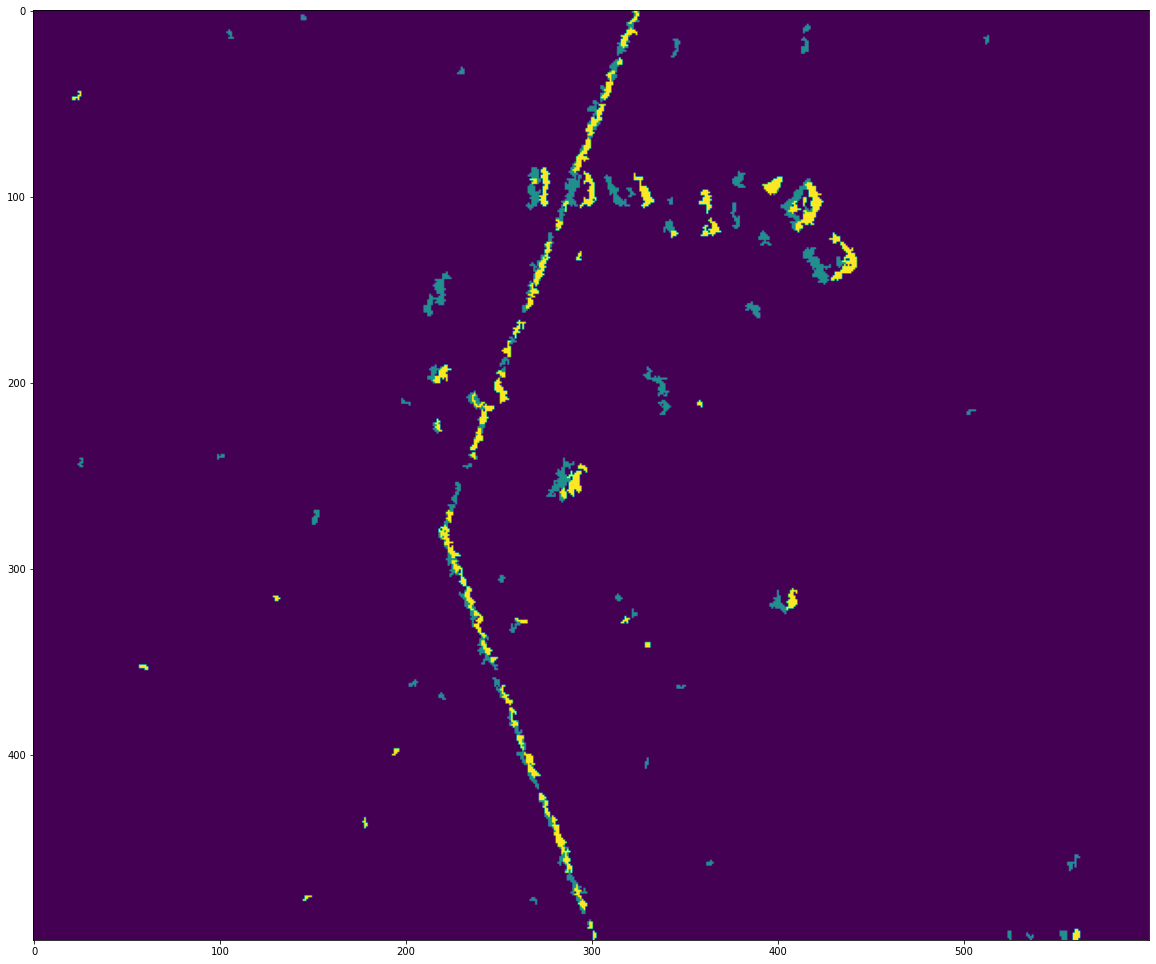

In [18]:
out = np.zeros_like(t)
for i in range(2):
    where = shadows[i] != -1
    out[where] = i + 1
# fig, ax = plt.subplots(1)
# ax.imshow(t, cmap = cm.get_cmap('Greys'))
# ax.imshow(np.ma.masked_where(shadows[0] == -1, shadows[0]), cmap=plt.get_cmap('Blues'))
# ax.imshow(np.ma.masked_where(shadows[1] == -1, shadows[1]), cmap=plt.get_cmap('Reds'))

# cv2.imshow(t)
plt.imshow(out)
# plt.imsave("out.png", out)
np.save('out', out)